### Data Description ###

Our chosen dataset, the *players.csv* file, has a total of 196 observations. These observations include players':
- Experience level (chr)
   - (Beginner, Amateur, Regular, Pro, and Veteran)
- Subscription status (lgl)
   - Whether or not they're subscribed to the newsletter
- Played hours (dbl)
- Name (chr)
- Gender (chr)
- Age (int)
- Email hash code (chr)
   - A long string of letters and numbers uniquely identifying each player

for a total of 7 variables.

The players in this dataset have an average played hours of 5.85 and an average age of 20.52. The distribution of experience levels is as follows:

- Beginner: 17.86%
- Amateur: 32.14%
- Regular: 18.37%
- Pro: 7.14%
- Veteran: 24.49%

Currently, 73.47% of players are subscribed to the newsletter, while 26.53% are not.

One issue I see with the data is that a large portion of players have played very few or 0 hours. Specifically, roughly 74% of players have only 0.5 hours played or less. This heavily skews the data, making it difficult to use *played_hours* to make our predictions. We also do not know the accuracy of reporting. Some individuals could claim that they are Pro players, but without a clear benchmark for them being classified as Pro, it may be tough to determine whether or not this is accurate.

### Questions ###

The broad question we've chosen is: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Our specific question is: Does played hours or age most accurately predict a player's subscription status in *players.csv*?

By using the *players* dataset, we can manipulate our data into a training and testing set, 75% and 25% respectively. We will then use cross-validation to find the k value (number of neighbours) with the highest accuracy value, testing k from 2-10. Finally, we will use k-nearest neighbours classification using the k value determined in our cross-validation to predict our target variable, *subscribed*.

### Data Analysis & Visualization ###

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(janitor)
library(gridExtra)
options(repr.matrix.max.rows = 7, repr.plot.height = 4, repr.plot.width = 14)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


avg_hours,avg_age
<dbl>,<dbl>
5.85,20.52


`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


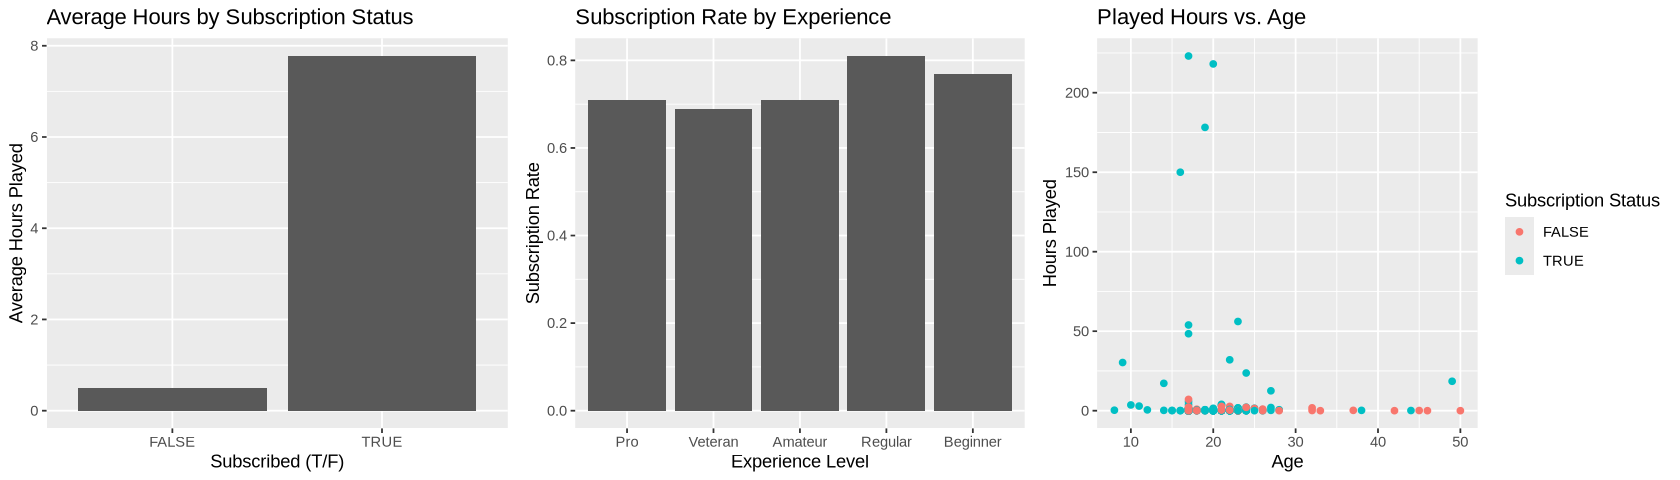

In [2]:
players <- read_csv('players.csv') |>
    clean_names() |>
    mutate(experience = as_factor(experience)) |>
    mutate(age = as.integer(age))

avg_played_hours <- players |>
    summarize(avg_hours = mean(played_hours)) |>
    pull()

avg_age <- players |>
    summarize(avg_age = mean(age, na.rm = TRUE)) |>
    pull()

averages <- tibble(avg_hours = round(avg_played_hours, 2), avg_age = round(avg_age, 2))

averages

avg_hours_plot <- players |>
    group_by(subscribe) |>
    summarize(avg_hours = mean(played_hours)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    ggplot(aes(x = subscribe, y = avg_hours)) +
        geom_bar(stat = "identity") +  
        labs(title = 'Average Hours by Subscription Status', 
             x = 'Subscribed (T/F)', 
             y = 'Average Hours Played')

total_experience <- players |>
    group_by(experience) |>
    summarize(count = n()) |>
    select(count)

subscribed_experience <- players |>
    group_by(experience, subscribe) |>
    summarize(subscription = n()) |>
    filter(subscribe == "TRUE") |>
    bind_cols(total_experience) |>
    mutate(subscription_rate = round(subscription/count, 2))

sub_rate_by_experience_plot <- subscribed_experience |>
    ggplot(aes(x = experience, y = subscription_rate)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Experience Level',
             y = 'Subscription Rate',
             title = 'Subscription Rate by Experience')

age_vs_hours_plot <- players |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
        geom_point() +
        labs(x = 'Age',
             y = 'Hours Played',
             colour = 'Subscription Status',
             title = 'Played Hours vs. Age')

grid.arrange(avg_hours_plot, 
             sub_rate_by_experience_plot, 
             age_vs_hours_plot, 
             ncol = 3, widths = c(4, 4, 5))

It appears that there is a correlation between subscription status and average hours played, with those who are subscribed having a significantly higher average hours played. There also appears to be a slight correlation between age and subscription, as a majority of the subscribed individuals are below the age of 30. There seems to be a slightly higher rate of subscription in regular and beginner players than other experience levels, although it is not super notable.

### Methods and Plan ###

Our plan is to use our different predictor variables separately to attempt to classify subscription status, and then analyze the accuracy of each one to come up with an answer to our broad question.

Why is this method appropriate?

- It allows us to directly compare our variables to determine which predicts our variable of interest most accurately

Which assumptions are required, if any, to apply the method selected?

- We assume that players' ages and experience levels are reported accurately, and that this dataset accurately represents the greater population, given n > 30

What are the potential limitations or weaknesses of the method selected?

- By using classification instead of regression, 

How are you going to compare and select the model?

- By comparing the accuracies, using the metrics() function to analyze each variables accuracy
- We will also use cross-validation using vfold_cv() and tune_grid() to determine the amount of neighbours to use for each

How are you going to process the data to apply the model?

- We will split the data into training and testing, with a 75/25 split
- Our training data will be split into 5 folds for cross-validation
- We will then use accuracy to determine the best k value, picking the one with the highest accuracy
- Finally we will apply our fitted model onto the test data, 